In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### 1
В данном задании вам нужно будет

1. проанализировать АБ тест, проведенный на реальных пользователях Яндекса


2. подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами


3. определить характер этих изменений и практическую значимость вводимого изменения


4. понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)


Описание данных:


- userID: уникальный идентификатор пользователя


- browser: браузер, который использовал userID


- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)


- n_clicks: количество кликов, которые пользоваль совершил за n_queries


- n_queries: количество запросов, который совершил userID, пользуясь браузером browser


- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика


Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.


Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.


Полученный процент округлите до третьего знака после точки.


In [2]:
df = pd.read_csv("ab_browser_test.csv")
df.shape

(566134, 6)

In [3]:
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
exp_clicks = df[df.slot == "exp"].n_clicks.values
control_clicks = df[df.slot == "control"].n_clicks.values

In [5]:
round(exp_clicks.sum() / control_clicks.sum() * 100 - 100, 3)

1.614

---
### 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.


- 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо $\large\checkmark$


- 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо $\large\checkmark$

In [6]:
# функция из лекций
def get_bootstrap_samples(data, n_samples=500):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
# функция из лекций
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [25]:
np.random.seed(0)
boot_exp = get_bootstrap_samples(exp_clicks)

In [7]:
np.random.seed(0)
boot_control = get_bootstrap_samples(control_clicks)

In [11]:
delta_mean = boot_exp.mean(axis=1) - boot_control.mean(axis=1)
stat_intervals(delta_mean)

array([0.19308664, 0.41347123])

In [13]:
delta_mean = np.median(boot_exp, axis=1) - np.median(boot_control, axis=1)
stat_intervals(delta_mean)

array([1., 1.])

---
### 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

- Все ответы неверны $\large\checkmark$

---
### 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\large\frac{\overline{X} - \mu}{\sqrt{S^2/n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- $\overline{X}$ — среднее значение в выборке — было распределено нормально $N(\mu, \frac{\sigma^2}{n})$


- $\frac{n}{\sigma^2}S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n-1$ степенями свободы $\chi^2(n-1)$
---

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

---
Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

---

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.


2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (**control_boot_chi_squared**)


3. Для получившегося вектора средних значений из **n_boot_samples** постройте **q-q plot** с помощью **scipy.stats.probplot** для нормального распределения


4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте **qq-plot** с помощью **scipy.stats.probplot** для хи-квадрат распределения с помощью команды *scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)*. 


Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

np.random.seed(0)
n_boot_samples = 500

---
В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

---



- $R^2$  для выборочного среднего получился меньше, чем 0.99 


- $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился меньше, чем 0.99


- $R^2$ для выборочного среднего получился больше, чем 0.99 $\large\checkmark$


- $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99 $\large\checkmark$



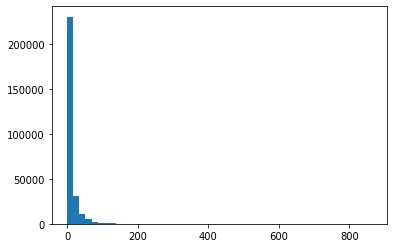

In [10]:
plt.hist(control_clicks, 50);

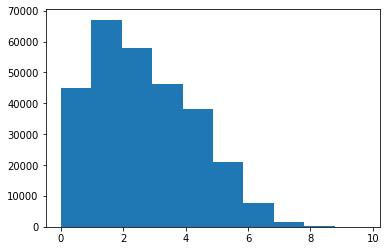

In [22]:
plt.hist(np.log2(control_clicks + 1));

In [9]:
#  Получите из данных n_boot_samples псевдовыборок
boot_control.shape

(500, 284554)

In [10]:
# По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего
boot_c_means = np.mean(boot_control, axis=1)

In [15]:
boot_c_var = boot_control.var(axis=1)

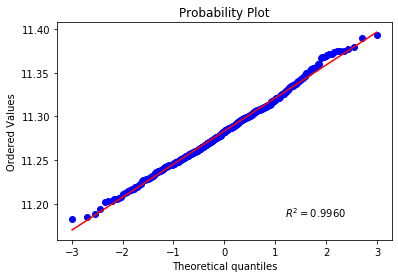

In [19]:
# Для получившегося вектора средних значений из n_boot_samples постройте q-q plot
stats.probplot(boot_c_means, plot=plt, rvalue=True);

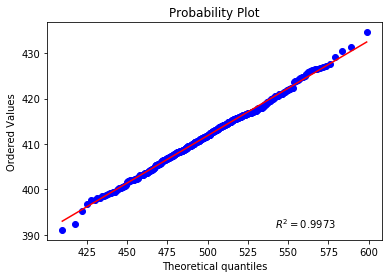

In [18]:
# Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot 
stats.probplot(boot_c_var, dist="chi2", sparams=499,  plot=plt, rvalue=True);

---
### 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

- Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками $\large\checkmark$


In [22]:
df.head(2)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2


In [31]:
stats.mannwhitneyu(
    df.loc[df.slot == "exp"].groupby(['userID', 'browser']).sum().n_clicks,
    df.loc[df.slot == "control"].groupby(['userID', 'browser']).sum().n_clicks,
    alternative="two-sided"
)

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

---
### 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [42]:
brow_exp_cl = df.loc[df.slot == "exp"].groupby(['browser', 'userID']).sum().n_clicks
brow_control_cl = df.loc[df.slot == "control"].groupby(['browser', 'userID']).sum().n_clicks

In [40]:
df.browser.unique()

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [48]:
from statsmodels.sandbox.stats.multicomp import multipletests 


In [61]:
mw_p = list()
names = df.browser.unique()
mw_p = [stats.mannwhitneyu(brow_exp_cl[name], brow_control_cl[name])[1] for name in names]
list(zip(mw_p, names))

[(0.0272438604197241, 'Browser #2'),
 (0.40760617658454984, 'Browser #4'),
 (0.0, 'Browser #14'),
 (0.03740060143010802, 'Browser #17'),
 (0.45366656388735377, 'Browser #20'),
 (0.2574055152210032, 'Browser #22')]

In [65]:
res = multipletests(mw_p, method="holm")
res

(array([False, False,  True, False, False, False]),
 array([0.1362193 , 0.81521235, 0.        , 0.14960241, 0.81521235,
        0.77221655]),
 0.008512444610847103,
 0.008333333333333333)

In [66]:
(res[0] == False).sum()

5

---
### 7
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений **n_nonclk_queries** на сумму значений **n_queries**. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.


- По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы. 


- По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей. 


- **С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно**


- Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей.



In [91]:
exp = df.loc[df.slot == "exp", ["browser", "n_nonclk_queries", "n_queries"]].groupby(['browser']).sum()
control = df.loc[df.slot == "control", ["browser", "n_nonclk_queries", "n_queries"]].groupby(['browser']).sum()

In [108]:
val_e = np.round(exp.n_nonclk_queries / exp.n_queries * 100, 2).values
val_c = np.round(control.n_nonclk_queries / control.n_queries * 100, 2).values
print(*list(zip(names, val_c, val_e)), sep="\n")

('Browser #2', 57.59, 43.76)
('Browser #4', 36.3, 36.94)
('Browser #14', 45.96, 44.98)
('Browser #17', 40.54, 38.98)
('Browser #20', 40.59, 39.85)
('Browser #22', 46.97, 45.14)
